## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

2025-09-26 20:10:55.004452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758917455.155188      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758917455.198322      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load the Dataset

In [2]:
TRAIN_DIR = '/kaggle/input/face-expression-recognition-dataset/images/train'
TEST_DIR = '/kaggle/input/face-expression-recognition-dataset/images/validation'

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            image_path = os.path.join(label_dir, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [4]:
## Convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
## Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/face-expression-recognition-data...,fear
1,/kaggle/input/face-expression-recognition-data...,angry
2,/kaggle/input/face-expression-recognition-data...,surprise
3,/kaggle/input/face-expression-recognition-data...,happy
4,/kaggle/input/face-expression-recognition-data...,neutral


In [5]:
# Validation dataframe
validation = pd.DataFrame()
validation['image'], validation['label'] = load_dataset(TEST_DIR)

# Shuffle validation dataset
validation = validation.sample(frac=1).reset_index(drop=True)
validation.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/face-expression-recognition-data...,happy
1,/kaggle/input/face-expression-recognition-data...,sad
2,/kaggle/input/face-expression-recognition-data...,surprise
3,/kaggle/input/face-expression-recognition-data...,happy
4,/kaggle/input/face-expression-recognition-data...,fear


## Exploratory Data Analysis

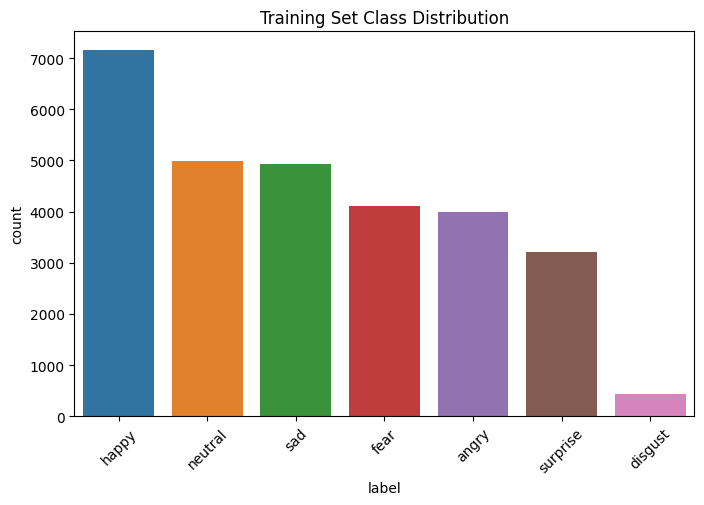

In [6]:
plt.figure(figsize=(8,5))
sns.countplot(data=train, x='label', order=train['label'].value_counts().index)
plt.title("Training Set Class Distribution")
plt.xticks(rotation=45)
plt.show()

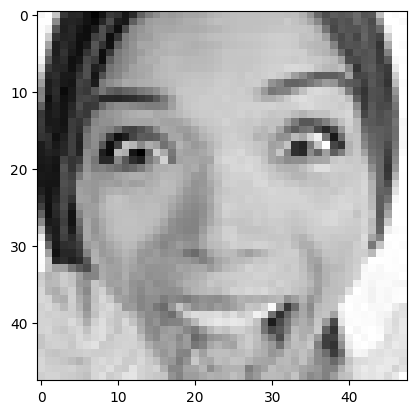

In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

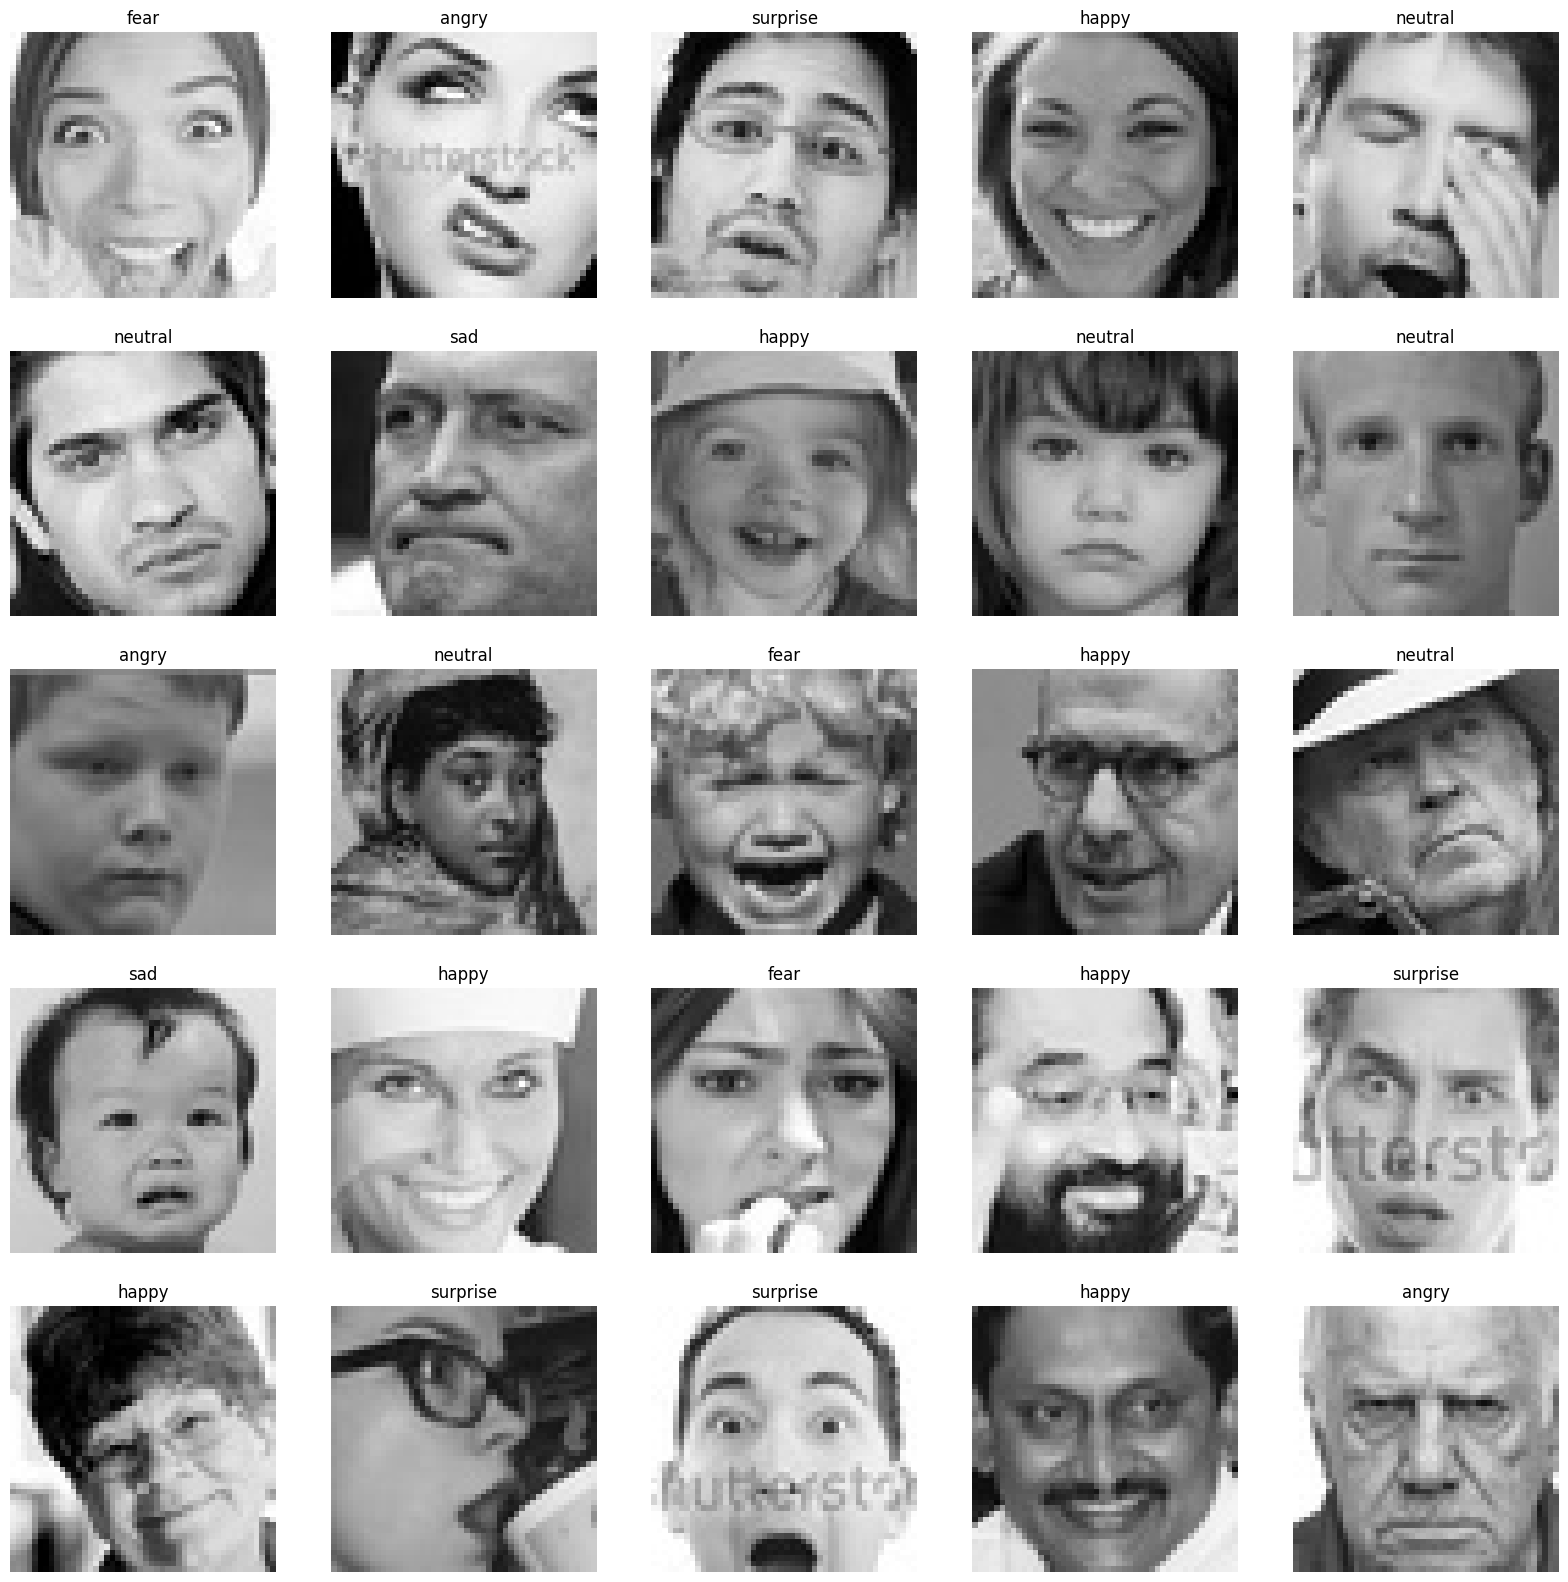

In [8]:
from tensorflow.keras.utils import load_img

# Display a grid of 25 images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)           # load the image
    img = np.array(img)            # convert to array
    plt.imshow(img, cmap='gray')   # dataset is grayscale
    plt.title(label)               # fixed typo
    plt.axis('off')

plt.show()

## Feature Extraction from Images

In [9]:
from tensorflow.keras.utils import load_img
import numpy as np
from tqdm.notebook import tqdm

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')  # <- use color_mode instead of grayscale
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [10]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

In [11]:
validation_features = extract_features(validation['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [12]:
## Normalize the image
x_train = train_features/255.0
x_validation = validation_features/255.0

In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
le = LabelEncoder()
le.fit(train['label'])

# Transform labels to integers
y_train = le.transform(train['label'])
y_validation = le.transform(validation['label'])

In [14]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=7)
y_validation = to_categorical(y_validation, num_classes=7)

In [15]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.])

In [16]:
## Config
input_shape = (48, 48, 1)
output_class = 7

## Model Creation

In [17]:
model = Sequential()

##Convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

## Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

## Output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1758917730.981006      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758917730.981624      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [18]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=100,
    validation_data=(x_validation, y_validation)
)

Epoch 1/100


I0000 00:00:1758917736.536554     111 service.cc:148] XLA service 0x44912cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758917736.537030     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758917736.537050     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758917736.958061     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/226 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.2270 - loss: 1.8964

I0000 00:00:1758917745.628782     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


226/226 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - accuracy: 0.2386 - loss: 1.8346 - val_accuracy: 0.2583 - val_loss: 1.8036
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.2499 - loss: 1.8041 - val_accuracy: 0.2924 - val_loss: 1.7303
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.2930 - loss: 1.7222 - val_accuracy: 0.3749 - val_loss: 1.5552
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.3668 - loss: 1.5973 - val_accuracy: 0.4519 - val_loss: 1.4452
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.4149 - loss: 1.4927 - val_accuracy: 0.4917 - val_loss: 1.3390
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.4506 - loss: 1.4219 - val_accuracy: 0.4983 - val_loss: 1.3037
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.4626 - loss: 1.3874 - val_accuracy: 0.5173 - val_loss: 1.2568
Epoch 8/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.4797 - loss: 1.3522 - val_

## Plot the Results

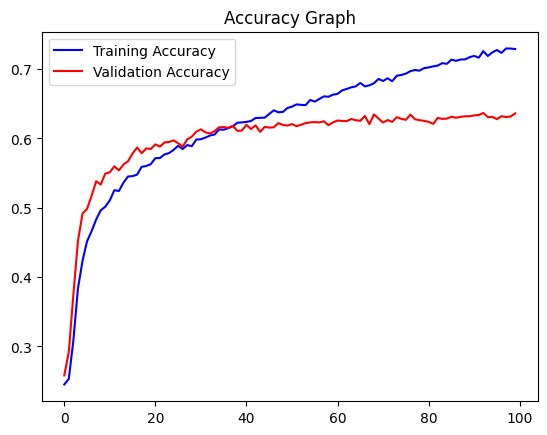

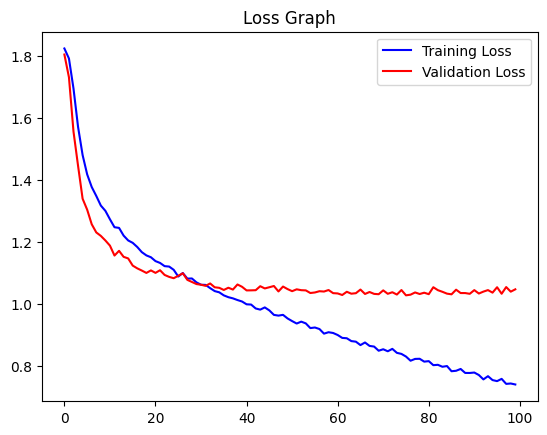

In [21]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']  
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()


## Test with Image Data

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Output: happy


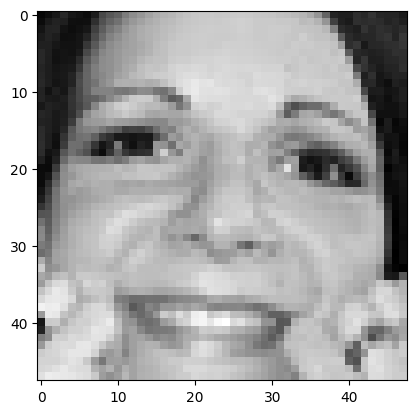

In [25]:
image_index = random.randint(0, len(validation) - 1)
print("Original Output:", validation['label'][image_index])

# Use x_validation instead of x_test
pred = model.predict(x_validation[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])
print("Predicted Output:", prediction_label[0])

plt.imshow(x_validation[image_index].reshape(48, 48), cmap='gray')
plt.show()